# Radial Basis Function [using PyTorch ]

**Description**:

RBF layers are an alternative to the activation functions used in regular artificial neural networks. Typically, each RBF layer in an RBF network is followed by a linear layer. In an RBF layer, the distances between the input and a number of positions called centres are calculated and scaled. Then an RBF is applied to each scaled distance. 
![](img/equation.PNG)
i.e, where the x's are the inputs, phi is a radial basis function, the sigmas are the scaling factors and the c's are the centres. Usually, the centre positions are found by clustering the data. This is impractical for RBF networks with many RBF layers. In this implementation, the centres and scaling factors are trained with gradient descent, which allows for RBF networks with many RBF layers.

![](img/architecture_simple2.png)

In [2]:
import torch_rbf as rbf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

# Model creating

In [4]:
class Network(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(rbf.RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    
    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        self.train()
        obs = x.size(0)
        trainset = MyDataset(x, y)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()

In [5]:
x1 = np.linspace(-1, 1, 101)
x2 = 0.5*np.cos(np.pi*x1) + 0.5*np.cos(4*np.pi*(x1+1)) # <- decision boundary

samples = 200
x = np.random.uniform(-1, 1, (samples, 2))
for i in range(samples):
    if i < samples//2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

steps = 100
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)



In [10]:
print(tx.shape, ty.shape)

torch.Size([200, 2]) torch.Size([200, 1])


# Data loading

Instanciating and training an RBF network with the Gaussian basis function.
This network receives a 2-dimensional input, transforms it into a 40-dimensional
hidden representation with an RBF layer and then transforms that into a
1-dimensional output/prediction with a linear layer.

To add more layers, change the layer_widths and layer_centres lists

In [11]:
layer_widths = [2, 1]
layer_centres = [40]
basis_func = rbf.gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, 5000, samples, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()

Epoch: 5000, Progress: 200/200, Loss: 0.001090      

Network(
  (rbf_layers): ModuleList(
    (0): RBF()
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=40, out_features=1, bias=True)
  )
)

# Error analysis

 Plotting the ideal and learned decision boundaries

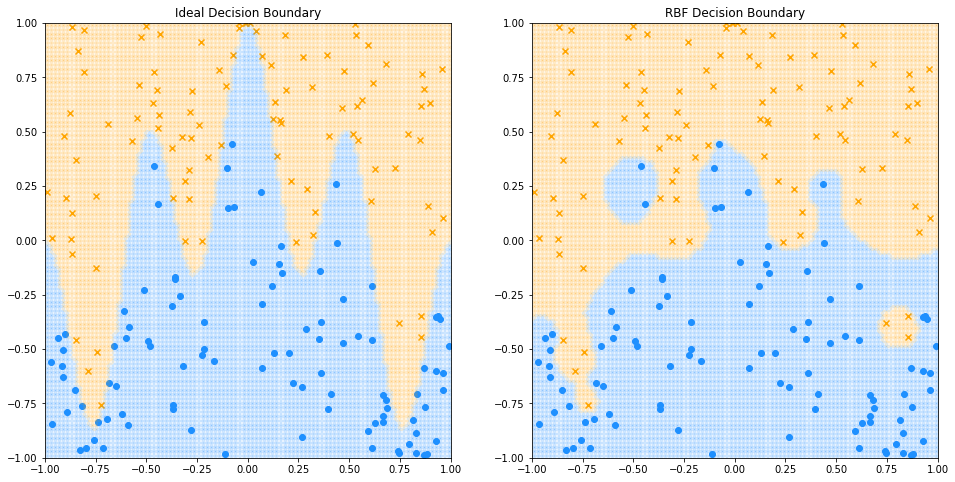

In [12]:
with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()
ideal_0 = values[np.where(values[:,1] <= 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
ideal_1 = values[np.where(values[:,1] > 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='orange')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_title('Ideal Decision Boundary')
ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='orange')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-1,1])
ax[1].set_title('RBF Decision Boundary')
plt.show()

# List of links to more detailed sources, tutorials, and alternative solutions
**using pytorch:** 
* https://github.com/csnstat/rbfn/blob/master/RBFN.py, 
* https://github.com/JeremyLinux/PyTorch-Radial-Basis-Function-Layer 

other:
* https://github.com/andrewdyates/Radial-Basis-Function-Neural-Network/blob/master/rbn.py
* https://github.com/eugeniashurko/rbfnnpy/blob/master/rbfnnpy.py
* https://mccormickml.com/2013/08/15/radial-basis-function-network-rbfn-tutorial/ - full description
